# Chapter 16 - Natural Language Processing with RNNs and Attention

## Exercise
1. What are the pros and cons of using a stateful RNN versus a stateless RNN?

**Jawaban:** 
- **Stateful RNN:**
  - **Pros:** Dapat mempertahankan state/memori antar batch, berguna untuk sequence yang sangat panjang, lebih efisien untuk prediksi real-time
  - **Cons:** Lebih kompleks untuk diimplementasikan, memerlukan pengelolaan state manual, sulit untuk parallelization
- **Stateless RNN:**
  - **Pros:** Lebih sederhana, mudah untuk training parallel, tidak perlu mengelola state secara manual
  - **Cons:** Tidak dapat mempertahankan informasi antar batch, terbatas untuk sequence pendek

2. Why do people use Encoder–Decoder RNNs rather than plain sequence-to-sequence RNNs for automatic translation?

**Jawaban:** Encoder-Decoder RNN lebih cocok untuk translation karena dapat menangani input dan output dengan panjang yang berbeda. Encoder memproses seluruh input sequence dan menghasilkan context vector yang merangkum informasi, kemudian Decoder menggunakan context ini untuk menghasilkan output sequence dengan panjang yang sesuai.

3. How can you deal with variable-length input sequences? What about variablelength output sequences?

**Jawaban:**
- **Variable-length input:** Gunakan padding untuk menyamakan panjang sequence, atau gunakan masking untuk mengabaikan padding tokens
- **Variable-length output:** Gunakan special tokens seperti <EOS> (End of Sequence) untuk menandai akhir sequence, atau gunakan dynamic decoding

4. What is beam search and why would you use it? What tool can you use to implement it?

**Jawaban:** Beam search adalah algoritma pencarian yang mempertahankan beberapa kandidat sequence terbaik (beam width) pada setiap langkah decoding, bukan hanya satu kandidat terbaik. Digunakan untuk meningkatkan kualitas output dengan mengeksplorasi lebih banyak kemungkinan. Dapat diimplementasikan menggunakan TensorFlow/Keras atau library seperti Hugging Face Transformers.

5. What is an attention mechanism? How does it help?

**Jawaban:** Attention mechanism memungkinkan model untuk "memperhatikan" bagian-bagian tertentu dari input sequence saat menghasilkan setiap output token. Ini membantu dengan memberikan akses langsung ke semua hidden states dari encoder, mengatasi masalah information bottleneck pada context vector, dan meningkatkan performa pada sequence yang panjang.

6. What is the most important layer in the Transformer architecture? What is its purpose?

**Jawaban:** Self-attention layer (Multi-Head Attention) adalah layer paling penting dalam Transformer. Tujuannya adalah untuk memungkinkan setiap posisi dalam sequence untuk "memperhatikan" semua posisi lain dalam sequence yang sama, memungkinkan pemahaman hubungan jarak jauh tanpa keterbatasan sequential processing seperti pada RNN.

7. When would you need to use sampled softmax?

**Jawaban:** Sampled softmax digunakan ketika vocabulary size sangat besar (misalnya puluhan ribu atau ratusan ribu kata), yang membuat komputasi full softmax menjadi sangat mahal. Ini umum digunakan dalam language modeling, machine translation, atau NLP tasks lain dengan vocabulary besar untuk mempercepat training.

## Sentiment Analysis

Menggunakan dataset imdb

In [3]:
import tensorflow as tf

In [11]:
import keras

In [1]:
import tensorflow_datasets as tfds

In [2]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 1/1 [00:29<00:00, 29.31s/ url]
                                                                        

Dataset imdb_reviews downloaded and prepared to C:\Users\USER\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [4]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [5]:
from collections import Counter
vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [6]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [7]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [8]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [9]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [10]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch
train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [12]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
            input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
            metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5


c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.5049 - loss: 0.6937
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.6055 - loss: 0.6361
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.8140 - loss: 0.4104
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.8865 - loss: 0.2782
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9424 - loss: 0.1658


## Automatic Translation

In [13]:
tf.random.set_seed(42)

In [14]:

vocab_size = 100
embed_size = 10

In [17]:
import numpy as np

In [20]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")


In [23]:
tf.keras.backend.clear_session()

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

decoder_lstm = keras.layers.LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embeddings, initial_state=encoder_state)

output_layer = keras.layers.Dense(vocab_size, activation='softmax')
Y_proba = output_layer(decoder_outputs)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]

history = model.fit([X, X_decoder], Y, epochs=2)

Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.6054
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.6027


### Bidirectional Recurrent Layers

In [24]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, None, 10)       │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 20)       │         1,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,980 (7.73 KB)

 Trainable params: 1,980 (7.73 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [26]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

In [28]:
import matplotlib.pyplot as plt

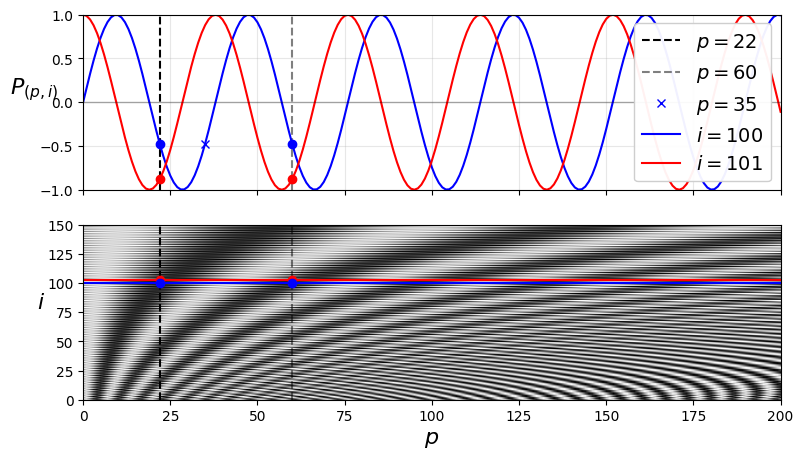

In [ ]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

## Exercise Code 8

In [32]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

In [33]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

In [34]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

In [35]:

POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

In [36]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

In [37]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [38]:

string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

In [40]:

def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [41]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

In [42]:

X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

In [43]:

y_train[0]

array([1.])

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.Lambda(lambda x: x.to_tensor()),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4925 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4916 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4955 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4931 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4960 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4941 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4952 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4952 - loss: 0.6939 - val_accuracy: 0.

In [46]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 52.14%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 52.06%


## Exercise Code 9

In [47]:
from datetime import date

MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [48]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [49]:

INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [50]:

OUTPUT_CHARS = "0123456789-"

In [51]:

def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [52]:

date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [53]:

date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [54]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [55]:

np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [56]:

Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

In [57]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3075 - loss: 1.9639 - val_accuracy: 0.5767 - val_loss: 1.1862
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6176 - loss: 1.0668 - val_accuracy: 0.7120 - val_loss: 0.7643
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7279 - loss: 0.7023 - val_accuracy: 0.7837 - val_loss: 0.5295
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8115 - loss: 0.4705 - val_accuracy: 0.8681 - val_loss: 0.3397
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6202 - loss: 1.0947 - val_accuracy: 0.8708 - val_loss: 0.3638
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8947 - loss: 0.3025 - val_accuracy: 0.9317 - val_loss: 0.2126
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9435 - loss: 0.1855 - val_accuracy: 0.9681 - val_loss: 0.1224
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9771 - loss: 0.0990 - val_accuracy: 0.9862 

In [58]:

def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

In [59]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])


In [60]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
2009-09-17
1789-07-14


In [61]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])


In [62]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2020-01-02
1789-09-14


In [63]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    #ids = model.predict_classes(X)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids)

In [64]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


['2020-05-02', '1789-07-14']